In [1]:
!pip install transformers
!pip install wget

     |████████████████████████████████| 2.3MB 8.3MB/s 
     |████████████████████████████████| 901kB 50.7MB/s 
     |████████████████████████████████| 3.3MB 54.0MB/s 
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=b0ea67e89183c184946b0e695d84f68f9e3c833af4bdcda62925bb29b2be041d
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
# Datenvorbereitung
import json
import wget

# download and open json file
url = 'https://raw.githubusercontent.com/Johannes96/BERT_fineTune/master/data/final_train_ae_CLS.json'
dataset1 = wget.download(url)

with open(dataset1) as json_file:
    train_ae = json.load(json_file)

url =  'https://raw.githubusercontent.com/Johannes96/BERT_fineTune/master/data/final_dev_ae_CLS.json'
dataset2 = wget.download(url)

with open(dataset2) as json_file:
    val_ae = json.load(json_file)

# Extrahiere Sätze und Labels
train_texts = []
train_tags = []
for i in train_ae:
    train_tags.append(train_ae[i]['label'])
    train_texts.append(train_ae[i]['sentence'])

val_texts = []
val_tags = []
for i in val_ae:
    val_tags.append(val_ae[i]['label'])
    val_texts.append(val_ae[i]['sentence'])

# Vereinige Trainings- und Testdaten
texts = train_texts
tags = train_tags
tags.extend(val_tags)
texts.extend(val_texts)

In [3]:
# Bereinige Datensatz von '\x85'
for i, sent in enumerate(texts):
  for i2, word in enumerate(texts[i]):
    if word == '\x85':
      print('sent:', i, 'word:',i2)
      del texts[i][i2]
      del tags[i][i2]

sent: 3600 word: 5
sent: 3655 word: 5
sent: 3924 word: 5
sent: 6585 word: 5


In [4]:
# Teile in Trainigns- und Testdaten auf
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_tags, val_tags = train_test_split(texts, tags, test_size=.2)

In [5]:
# unique_tags = set(tag for doc in train_tags for tag in doc)
unique_tags = {'O', 'B', 'I'}
# tag2id = {tag: id for id, tag in enumerate(unique_tags)}
tag2id = {'O': 0, 'B': 1, 'I': 2}
# id2tag = {id: tag for tag, id in tag2id.items()}
id2tag = {0: 'O', 1: 'B', 2: 'I'}
print(tag2id)
print(id2tag)
print(unique_tags)

{'O': 0, 'B': 1, 'I': 2}
{0: 'O', 1: 'B', 2: 'I'}
{'I', 'O', 'B'}


In [6]:
# Tokenization
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
train_encodings = tokenizer(train_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)
val_encodings = tokenizer(val_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)

In [7]:
import numpy as np

def encode_tags(tags, encodings):
    labels = [[tag2id[tag] for tag in doc] for doc in tags]
    encoded_labels = []
    for i, (doc_labels, doc_offset) in enumerate(zip(labels, encodings.offset_mapping)):
        # create an empty array of -100
        # print(i)
        doc_enc_labels = np.ones(len(doc_offset),dtype=int) * -100
        arr_offset = np.array(doc_offset)
        # set labels whose first offset position is 0 and the second is not 0
        doc_enc_labels[(arr_offset[:,0] == 0) & (arr_offset[:,1] != 0)] = doc_labels
        encoded_labels.append(doc_enc_labels.tolist())
    return encoded_labels

train_labels = encode_tags(train_tags, train_encodings)
val_labels = encode_tags(val_tags, val_encodings)

In [8]:
import torch

class AEDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_encodings.pop("offset_mapping") # we don't want to pass this to the model
val_encodings.pop("offset_mapping")
train_dataset = AEDataset(train_encodings, train_labels)
val_dataset = AEDataset(val_encodings, val_labels)

In [9]:
# Spezifiziere Anzahl der labels
from transformers import BertForTokenClassification
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(unique_tags))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [10]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Step,Training Loss
10,1.062800
20,0.978600
30,0.845400
40,0.631900
50,0.450600
60,0.377100
70,0.295000
80,0.252500
90,0.234800
100,0.200600


Step,Training Loss
10,1.062800
20,0.978600
30,0.845400
40,0.631900
50,0.450600
60,0.377100
70,0.295000
80,0.252500
90,0.234800
100,0.200600


TrainOutput(global_step=1152, training_loss=0.12381483818171546, metrics={'train_runtime': 490.4162, 'train_samples_per_second': 2.349, 'total_flos': 190823036651280.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 2369036288, 'init_mem_gpu_alloc_delta': 431416832, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 105635840, 'train_mem_gpu_alloc_delta': 1333511168, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 1713818112})

In [11]:
trainer.evaluate()

{'epoch': 3.0,
 'eval_loss': 0.12995122373104095,
 'eval_mem_cpu_alloc_delta': 221184,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 218603008,
 'eval_runtime': 8.8531,
 'eval_samples_per_second': 173.274}

In [12]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b3873962-7806-b197-f9c2-32c76dc8e564)


In [33]:
val_encodings = tokenizer(val_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True, truncation=True)

class AEDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

val_encodings.pop("offset_mapping")
val_dataset = AEDataset(val_encodings)

predictions = trainer.predict(val_dataset)

pred_labels = []
val_labels2 = []
for i, pred in enumerate(predictions.predictions):
  max_len = len(val_texts[i])
  pred_labels.append(pred[0:max_len])
  val_labels2.append(val_labels[i][0:max_len])

In [26]:
# Erstelle Liste mit predicted values
pred_labels2 = []
for i, sent in enumerate(pred_labels):
  pred_labels2.append([])
  for ix, word in enumerate(sent):
    idx = max(range(len(pred_labels[i][ix])), key=pred_labels[i][ix].__getitem__)
    pred_labels2[i].append(idx)

val_labels3 = []
pred_labels3 = []
# Entferne alle Werte mit 0 oder -100
for i, preds in enumerate(val_labels2):
  for idx, word in enumerate(val_labels2[i]):
    if word == 1 or word == 2:
      pred_labels3.append(pred_labels2[i][idx])
      val_labels3.append(word)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 2, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 2, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 2, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 

In [30]:
# Berechne Metriken MSE, Confusion-Martix und F1-Score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

mse = mean_squared_error(val_labels3, pred_labels3)
accuracy = accuracy_score(val_labels3, pred_labels3)
f1 = f1_score(val_labels3, pred_labels3, average='macro') # zu klären welcher average-Wert verwendet werden soll
conf_matrix = confusion_matrix(val_labels3, pred_labels3)

print('MSE:', mse)
print('Accuracy:', accuracy)
print('F1-Score:', f1)
print('Confusion Matrix:\n', conf_matrix)

MSE: 0.5253456221198156
Accuracy: 0.7551020408163265
F1-Score: 0.5508114618993281
Confusion Matrix:
 [[  0   0   0]
 [192 841  18]
 [142  20 306]]


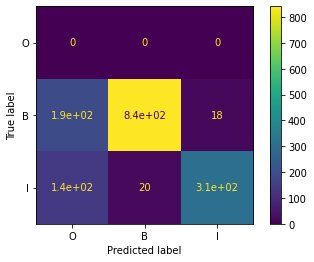

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
lab = ['O','B','I']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lab)
disp.plot()